# LSTM đơn biến - VN30 index

Mô hình LSTM đơn biến được xây dựng chỉ dựa trên chuỗi giá đóng cửa
 (Close) từ các bộ dữ liệu

## Import các thư viện cần thiết

In [1]:
import sys
import numpy as np
np.random.seed(1)

import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(2)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import optimizers

from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
from tensorflow.keras.optimizers import Adam


2025-06-02 01:39:47.503027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748828387.951039      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748828388.071286      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
plt.style.use('ggplot')

## Hàm callback

In [3]:
earlystopping = EarlyStopping(monitor= 'val_loss', min_delta= 0.0001, patience = 80, verbose= 1, mode= 'min')
checkpoint = ModelCheckpoint(
    filepath="best_model.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystopping, checkpoint]

## Đọc dữ liệu từ file csv

In [ ]:
url = r"VN30 Index.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [5]:
print(df.head)

<bound method NDFrame.head of                open     high      low    close       volume
time                                                       
2009-01-05   311.23   311.23   311.23   311.23          NaN
2009-01-06   314.21   314.21   314.21   314.21          NaN
2009-01-07   320.53   320.53   320.53   320.53          NaN
2009-01-08   314.14   314.14   314.14   314.14          NaN
2009-01-09   312.90   312.90   312.90   312.90          NaN
...             ...      ...      ...      ...          ...
2025-03-14  1387.08  1394.39  1385.20  1387.03  374490000.0
2025-03-17  1392.75  1397.28  1389.42  1394.90  352180000.0
2025-03-18  1398.44  1400.38  1388.64  1388.64  291590000.0
2025-03-19  1385.92  1386.57  1374.83  1377.63  363360000.0
2025-03-20  1382.23  1388.37  1371.98  1378.95  359980000.0

[4044 rows x 5 columns]>


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [6]:
print(df.isnull().sum())

open        0
high        0
low         0
close       0
volume    859
dtype: int64


## Tiền xử lí dữ liệu

Phân tích xu hướng giá: Vẽ biểu đồ Close để quan sát biến động giá theo thời gian.

In [7]:
df.drop(df[df['volume'] == 0].index, inplace= True)

Text(0.5, 1.0, 'Changes in Closing Prices Over Time')

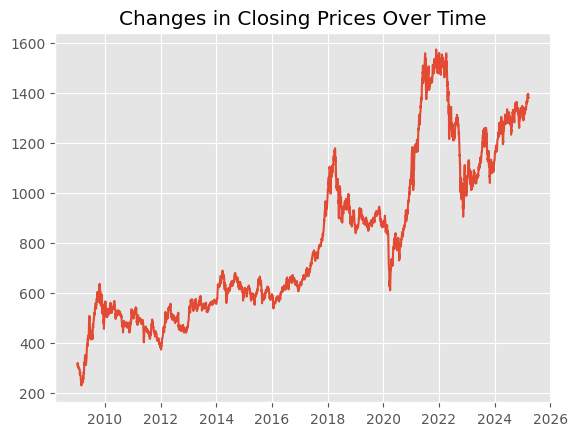

In [8]:
plt.plot(df['close'])
plt.title("Changes in Closing Prices Over Time")

## **fit_model** dùng để huấn luyện mô hình LSTM

In [9]:
# Định nghĩa hàm fit_model()
def fit_model(train, val, timesteps, hl, lr,  batch, epochs):
# Chuẩn bị dữ liệu huấn luyện và kiểm tra
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    
    # Tạo tập dữ liệu huấn luyện
    for i in range (timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    # Tạo tập dữ liệu kiểm tra
    for i in range (timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

# Xây dựng mô hình LSTM
    model = Sequential()
    model.add(LSTM(hl[0], input_shape= (X_train.shape[1], 1), return_sequences= True, activation= 'tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(hl[1], activation= 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
# Biên dịch mô hình
    model.compile(optimizer= Adam(learning_rate= lr), loss= 'mean_squared_error')     
# Huấn luyện mô hình
    history = model.fit(X_train, Y_train, epochs= epochs, batch_size= batch, validation_data= (X_val, Y_val), verbose= 1, shuffle= False, callbacks= callbacks_list)
# Đặt lại trạng thái của LSTM
    for layer in model.layers:
        if isinstance(layer, LSTM):
            layer.reset_states()
    return model, history.history['loss'], history.history['val_loss']

## **evaluate_model()** để đánh giá chất lượng mô hình LSTM

🔹 Các bước đánh giá mô hình:  
1. **Chuẩn bị dữ liệu kiểm tra** *(test data)*.  
2. **Dự đoán kết quả** với mô hình đã huấn luyện.  
3. **Tính toán các chỉ số đánh giá**:  
   - **MSE** (*Mean Squared Error*): Sai số bình phương trung bình.  
   - **RMSE** (*Root Mean Squared Error*): Căn bậc hai của MSE.  
   - **MAPE** (*Mean Absolute Percentage Error*): Sai số phần trăm tuyệt đối trung bình.  
   - **R² Score** (*Hệ số xác định*): Đánh giá mức độ phù hợp của mô hình.  


In [10]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Định nghĩa hàm mean_absolute_percentage_error() (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

# Định nghĩa hàm evaluate_model()
def evaluate_model(model, test, timesteps):
    # Chuẩn bị dữ liệu test
    X_test = []
    Y_test = []

    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Dự đoán
    Y_pred = model.predict(X_test)

    # Các chỉ số
    mse = mean_squared_error(y_true= Y_test, y_pred= Y_pred)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(y_true= Y_test, y_pred= Y_pred )
    r2 = r2_score(y_true= Y_test, y_pred= Y_pred)

    return mse, rmse, mape, r2, Y_test, Y_pred


# **Grid Search**: Tìm kiếm siêu tham số tối ưu

In [11]:
param_grid = {
    'timesteps': [30, 40, 50],
    'hl': [[40, 35]],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'num_epochs': [200]
}

In [12]:
from itertools import product # Tích đề-các
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
# Khởi tạo danh sách lưu kết quả
    results = []
    best_score = float('inf') # Ban đầu được đặt là vô cùng lớn
    best_params = None # Lưu bộ siêu tham số có hiệu suất tốt nhất
# Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())
# Lặp qua từng tổ hợp tham số
    for combination in all_combinations:
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

    print(f'Training with param: {params}')
# Huấn luyện với fit.model()
    model, train_loss, val_loss = fit_model(train, val, timesteps, hl, lr,  batch_size, num_epochs)
# Đánh giá mô hình với evaluate_model()
    mse, rmse, mape, r2, _, _ = evaluate_model(model, test, timesteps)
# Lưu kết quả
    results.append({
        'timesteps': timesteps,
        'hl': hl,
        'lr': lr,
        'batch_size': batch_size,
        'num_epochs': num_epochs,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    })
# Cập nhật bộ siêu tham số tốt nhất nếu RMSE cải thiện
    if rmse < best_score:
        best_score = rmse
        best_params = params

# Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df

# Xây dựng mô hình LSTM

## Bước 1: Trích xuất và trực quan hóa dữ liệu

(4044,)


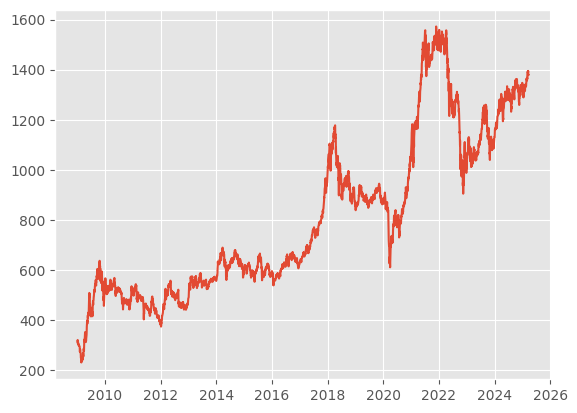

In [13]:
series = df['close']
print(series.shape)
plt.plot(series)

## Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [14]:
n = len(series)
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values.reshape(-1,1)
val_data = series.iloc[train_size:train_size + val_size].values.reshape(-1,1)
test_data = series.iloc[(train_size + val_size):].values.reshape(-1,1)

# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)

(2832, 1) (606, 1) (606, 1)


## Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [15]:
# Chuẩn hóa
sc = MinMaxScaler() # Tạo bộ chuẩn hóa MinMaxScaler
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(2832, 1) (606, 1) (606, 1)


## Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [16]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Bộ tham số tốt nhất (Best parameters):",best_params)
print("RMSE nhỏ nhất (Best score):", best_score)
print(results_df)


Training with param: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


I0000 00:00:1748828408.898604      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748828408.899322      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200


I0000 00:00:1748828414.517484      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1052
Epoch 1: val_loss improved from inf to 0.68440, saving model to best_model.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.1063 - val_loss: 0.6844
Epoch 2/200
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0207
Epoch 2: val_loss improved from 0.68440 to 0.14164, saving model to best_model.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0212 - val_loss: 0.1416
Epoch 3/200
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074
Epoch 3: val_loss improved from 0.14164 to 0.04789, saving model to best_model.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0075 - val_loss: 0.0479
Epoch 4/200
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088
Epoch 4: val_loss improved from 0.04789 to 0.03267, saving model to best_model.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0089 - val_loss: 0.0327
Epoch 5/200
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079
Epoch 5: val_loss improved from 0.03267 to 0.02140, saving mod

## Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [17]:
timesteps = 50
hl = [40, 35]
lr = 0.0001
batch_size = 64
num_epochs = 200

model, train_error, val_error = fit_model(train, val, timesteps, hl, lr, batch_size, num_epochs)


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0560
Epoch 1: val_loss did not improve from 0.00249
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0563 - val_loss: 0.1238
Epoch 2/200
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058
Epoch 2: val_loss did not improve from 0.00249
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - val_loss: 0.0532
Epoch 3/200
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055
Epoch 3: val_loss did not improve from 0.00249
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0058 - val_loss: 0.0385
Epoch 4/200
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054
Epoch 4: val_loss did not improve from 0.00249
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - val_loss: 0.0276
Epoch 5/200
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042
Epoch 5: val_loss did not improve from 0.00249
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - val_loss: 0.0194
Epoch 6/200
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035
Epoch 6: va

## Bước 6: Đánh giá mô hình và trực quan hóa kết quả

### 6.1. Vẽ biểu đồ train_loss và val_loss

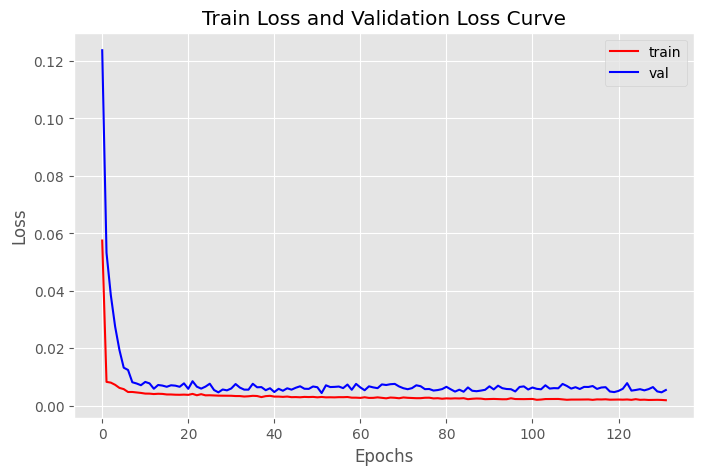

In [18]:
plt.figure(figsize=(8,5))
plt.plot(train_error, label= 'train', color= 'red')
plt.plot(val_error, label= 'val', color= 'blue')
plt.title('Train Loss and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 6.2. Đánh giá mô hình trên tập test

In [19]:
mse, rmse, mape, r2, true, predicted = evaluate_model(model, test, timesteps)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [20]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.0022704112273640156
RMSE = 0.047648832381958904
MAPE = 3.9066568288150014
R-Squared Score = 0.8250199985441959


### 6.3. Vẽ đồ thị dự đoán vs thực tế

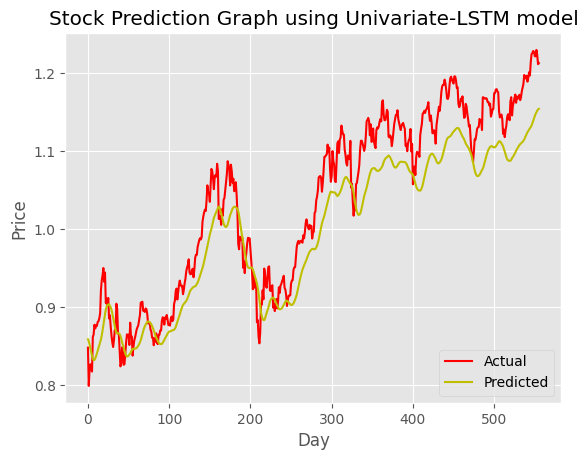

In [21]:
def plot_data(Y_test, Y_hat):
    plt.plot(Y_test, c='r')
    plt.plot(Y_hat, c='y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Univariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc='lower right')
    plt.show()

plot_data(true, predicted)